# Imports

In [6]:
! pip install neurobayes -q
! pip install atomai -q

! git clone https://github.com/gnganesh99/im2spec_bnn.git

Cloning into 'im2spec_bnn'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 37 (delta 17), reused 18 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 714.80 KiB | 10.21 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [7]:
import sys
sys.path.append('im2spec_pbnn')

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


import jax
import jax.numpy as jnp


In [9]:
import neurobayes as nb
from neurobayes.flax_nets import FlaxConvNet


In [10]:
from im2spec_bnn.BEPS_functions import *
from im2spec_bnn.im2spec_dataset import *
from im2spec_bnn.plot_functions import *
from im2spec_bnn.training_functions import *


# Get data

In [11]:
!gdown https://drive.google.com/uc?id=1XOEg7Lyqgz5QZT5rDfN_2aA6Ma_kj7nZ

Downloading...
From: https://drive.google.com/uc?id=1XOEg7Lyqgz5QZT5rDfN_2aA6Ma_kj7nZ
To: /content/PTO_BEPS_0d85um.npz
100% 5.14M/5.14M [00:00<00:00, 120MB/s]


Value Range: 0.0 1.0 0.0 1.0


Text(0, 0.5, 'Piezoresponse (a.u.)')

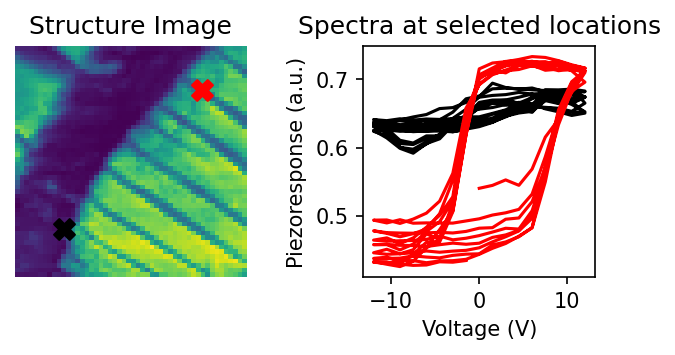

In [12]:
beps_file = r"/content/PTO_BEPS_0d85um.npz"

full_image, spectra, v_step = extract_beps_data(beps_file)
print("Value Range:", full_image.min(), full_image.max(), spectra.min(), spectra.max())

spec_pixel_x1 = 10; spec_pixel_y1 = 10
spec_pixel_x2 = 40; spec_pixel_y2 = 40

# Plot image and spectra at selected locations
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), dpi = 150)
plt.subplots_adjust(wspace=0.5)

ax1.imshow(full_image, origin = "lower")
ax1.scatter(spec_pixel_x1, spec_pixel_y1, marker='X', s=100, c='k')
ax1.scatter(spec_pixel_x2, spec_pixel_y2, marker='X', s=100, c='r')
ax1.set_title('Structure Image')
ax1.axis("off")

ax2.set_title("Spectra at selected locations")  # Note: Convention of the spectra indices is reversed!!!
ax2.plot(v_step, spectra[spec_pixel_y1, spec_pixel_x1], c = 'k')
ax2.plot(v_step, spectra[spec_pixel_y2, spec_pixel_x2], c = 'r')
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Piezoresponse (a.u.)')

(1225, 16, 16, 1) (1225, 256) (256,)


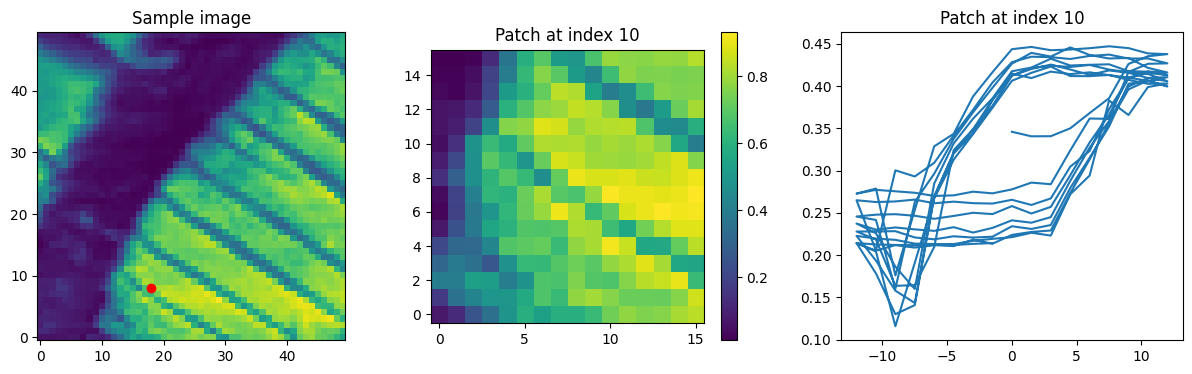

In [13]:
#images, spectra, coordinates = paired_images_spectra_1(full_image, cits_obj, hyperspectra, window_size = 20, coordinate_step = 10, image_norm=False, spectra_norm = False)
window_size = 16
images, spectra, coordinates, vstep = BEPS_image_spectral_pairs(beps_file, window_size = window_size, add_channel_NHWC=True)

print(images.shape, spectra.shape, vstep.shape)
h,w = images.shape[1], images.shape[2]
target_dim = spectra.shape[1]

fig, ax = plt.subplots(1, 3, figsize = (15, 4))

idx = 10

ax[0].imshow(full_image, origin = 'lower')
ax[0].scatter(coordinates[idx, 1], coordinates[idx, 0], c ="r")
ax[0].set_title("Sample image")


im = ax[1].imshow(images[idx], origin = 'lower')
fig.colorbar(im, ax=ax[1])
ax[1].set_title(f"Patch at index {idx}")
ax[2].plot(vstep, spectra[idx])
ax[2].set_title(f"Patch at index {idx}")

plt.show()

# Functions

In [23]:

def spectral_mismatch_error(pred_spectra, spectra):

    mse = np.mean(np.abs((pred_spectra - spectra)), axis=1)

    return mse

def augmented_dataset_numpy(images, spectra):

    images = images[:, :, :, 0]

    dataset = augmented_dataset(images, spectra)
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    for images, spectra in dataloader:
        images = images.numpy()
        spectra = spectra.numpy()

    images = images[..., np.newaxis]

    return images, spectra

# PBNN Model

In [18]:
#architecture = im2spec(target_size = 128, latent_dim = 3, nb_filters = 64)
architecture = FlaxConvNet(input_dim = 1, conv_layers = [32,64,64], fc_layers=[16, 32, 64, 128], target_dim=target_dim,  conv_dropout= 0.5, hidden_dropout = 0.3, output_dropout = 0.0)

# Add channel dimension to match the expected input shape
inputs = jnp.ones((1, h, w, 1))  # Shape: (batch_size, height, width, channels)
model_tab = architecture.tabulate(jax.random.PRNGKey(0), inputs, console_kwargs={"width": 200, "force_jupyter": True})


                                                        FlaxConvNet Summary                                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                                 ┃ module          ┃ inputs                 ┃ outputs             ┃ params                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                                      │ FlaxConvNet     │ float32[1,16,16,1]     │ float32[1,256]      │                          │
├──────────────────────────────────────┼─────────────────┼────────────────────────┼─────────────────────┼──────────────────────────┤
│ ConvLayerModule_0                    │ ConvLayerModule │ - float32[1,16,16,1]   │ float32[1,16,8,32]  │                          │
│                                      │                 │ - enable_dropout: True │                     │                          │
├──────────────────────────────────────┼─────────────────┼────────────────────────┼─────────────────────┼──────────────────────────┤
│ ConvLayerModule_0/Conv0              │ Conv            │ float32[1,16,16,1]     │ float32[1,16,16,32] │ bias: float32[32]        │
│                                      │                 │                        │                     │ kernel: float32[3,1,32]  │
│                                      │                 │                        │                     │                          │
│                                      │                 │                        │                     │ 128 (512 B)              │
├──────────────────────────────────────┼─────────────────┼────────────────────────┼─────────────────────┼──────────────────────────┤
│ ConvLayerModule_0/Dropout_0          │ Dropout         │ - float32[1,16,16,32]  │ float32[1,16,16,32] │                          │
│                                      │                 │ - deterministic: False │                     │                          │
├──────────────────────────────────────┼─────────────────┼────────────────────────┼─────────────────────┼──────────────────────────┤
│ ConvLayerModule_1                    │ ConvLayerModule │ - float32[1,16,8,32]   │ float32[1,16,4,64]  │                          │
│                                      │                 │ - enable_dropout: True │                     │                          │
├──────────────────────────────────────┼─────────────────┼────────────────────────┼─────────────────────┼──────────────────────────┤
│ ConvLayerModule_1/Conv1              │ Conv            │ float32[1,16,8,32]     │ float32[1,16,8,64]  │ bias: float32[64]        │
│                                      │                 │                        │                     │ kernel: float32[3,32,64] │
│                                      │                 │                        │                     │                          │
│                                      │                 │                        │                     │ 6,208 (24.8 KB)          │
├──────────────────────────────────────┼─────────────────┼────────────────────────┼─────────────────────┼──────────────────────────┤
│ ConvLayerModule_1/Dropout_0          │ Dropout         │ - float32[1,16,8,64]   │ float32[1,16,8,64]  │                          │
│                                      │                 │ - deterministic: False │                     │                          │
├──────────────────────────────────────┼─────────────────┼────────────────────────┼─────────────────────┼──────────────────────────┤
│ ConvLayerModule_2                    │ ConvLayerModule │ - float32[1,16,4,64]   │ float32[1,16,2,64]  │                          │
│                                      │                 │ - enable_dropout: True │                     │                          │
├─────────

In [58]:
in_dim = images[0].shape  # Input dimensions (image height and width)
out_dim = len(spectra[0])  # Output dimensions (spectra length)

test_size = 0.2


indices = np.arange(len(images))
imgs_train,imgs_test, spectra_train, spectra_test, indices_train, indices_test = train_test_split(images, spectra, indices, test_size = test_size, random_state = 24)

print(imgs_train.shape, spectra_train.shape, imgs_test.shape, spectra_test.shape)
initial_trainsize = imgs_train.shape[0]

(980, 16, 16, 1) (980, 256) (245, 16, 16, 1) (245, 256)


In [59]:
# Specify the names of probabilistic layers (output layer, 'Dense4', needs to be specified explicitly)
probabilistic_layer_names = [' ConvLayerModule_0/Conv0', 'FlaxMLP_0/MLPLayerModule_0/Dense0', 'FlaxMLP_0/MLPLayerModule_3/Dense3']  # MLP

# Intitalize and train a PBNN model
model = nb.PartialBNN(architecture, probabilistic_layer_names=probabilistic_layer_names)

images_to_train, spectra_to_train = augmented_dataset_numpy(imgs_train, spectra_train)
#images_to_train, spectra_to_train = imgs_train, spectra_train


print("Training set shape:", images_to_train.shape, spectra_to_train.shape)

model.fit(images_to_train, spectra_to_train, num_warmup=1000, num_samples=1000)

Training set shape: (2940, 16, 16, 1) (2940, 256)
Training deterministic NN...


Training Progress: 100%|██████████| 500/500 [00:23<00:00, 21.55it/s, Epoch 500/500, LR: 0.010000, Loss: 0.0376 ]


Training partially Bayesian NN


sample: 100%|██████████| 2000/2000 [01:01<00:00, 32.77it/s, 3 steps of size 2.25e-01. acc. prob=0.93]


(1225, 256) (1225, 256) (1225,) (1225,)
Spectral Mismatch Error: 0.08824816


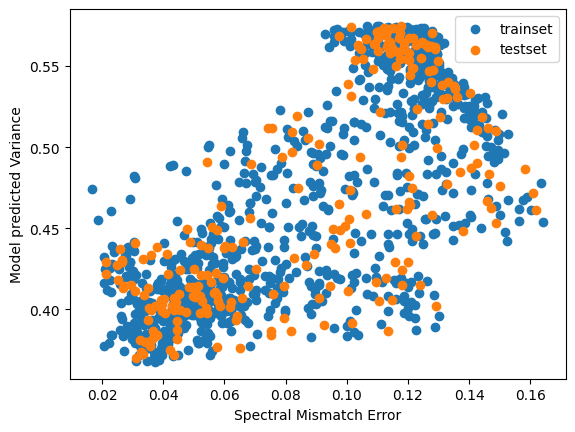

In [60]:
posterior_mean, posterior_var = model.predict(images)
cumulative_var = np.mean(posterior_mean, axis=1)


spectral_error = spectral_mismatch_error(posterior_mean, spectra)
print(posterior_mean.shape, posterior_var.shape, cumulative_var.shape, spectral_error.shape)
print("Spectral Mismatch Error:", spectral_error.mean())

plt.scatter(spectral_error[indices_train], cumulative_var[indices_train], label = 'trainset')
plt.scatter(spectral_error[indices_test], cumulative_var[indices_test], label = 'testset')

plt.xlabel("Spectral Mismatch Error")
plt.ylabel("Model predicted Variance")
plt.legend()
plt.show()


Index: 867


Text(0, 0.5, 'Signal (a.u.)')

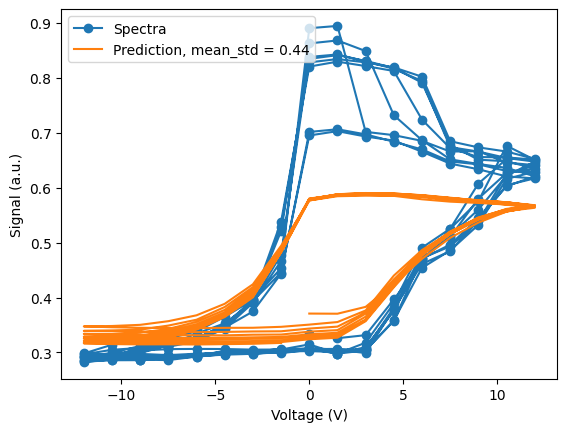

In [61]:
#ind = random.randint(minval= 0, maxval=len(spectra_test), 1)
import random
ind = random.choice(indices_test)
print("Index:", ind)

plt.plot(vstep, spectra[ind], 'o-', label="Spectra")
plt.plot(vstep, posterior_mean[ind], label=f'Prediction, mean_std = {cumulative_var[ind]:.2f}')
plt.legend()

plt.xlabel('Voltage (V)')
plt.ylabel('Signal (a.u.)')


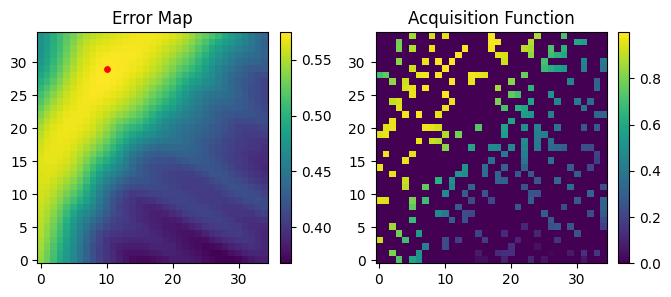

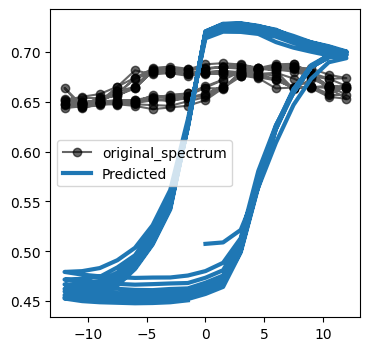

In [66]:
aq_ind, aq_vals = distance_acq_fn(cumulative_var, beta = 1, lambda_ = 1, optimize = "custom_fn", sample_next_points = 1, exclude_indices = indices_train)

plot_error_prediction(cumulative_var, aq_vals, coordinates, aq_ind)
for ind in aq_ind:
    plot_spectra([posterior_mean[ind]], spectra[ind], spectral_error[ind], xdata = vstep)

# Active learning

In [ ]:
prin

In [40]:
def train_model(architecture, probabilistic_layer_names, images_train, spectra_train, warmup_epochs = 1000, sample_epochs = 1000):

    model = nb.PartialBNN(architecture, probabilistic_layer_names= probabilistic_layer_names)

    model.fit(images_train, spectra_train, num_warmup=warmup_epochs, num_samples=sample_epochs)

    return model

In [41]:
beta = 1
test_size = 0.95
lambda_ = 0.1
sample_next_points = 5
augment_dataset = True


imgs_train, imgs_test, spectra_train, spectra_test, indices_train, indices_test = train_test_split(images, spectra, indices, test_size = test_size, random_state = 24)
initial_trainsize = imgs_train.shape[0]
print("Train/Test split:", imgs_train.shape, imgs_test.shape, spectra_train.shape, spectra_test.shape)

architecture = FlaxConvNet(input_dim = 2, conv_layers = [32,64,64], fc_layers=[32, 64, 128], target_dim=target_dim,  conv_dropout= 0.5, hidden_dropout = 0.3, output_dropout = 0.1)
probabilistic_layer_names = [' ConvLayerModule_0/Conv0', 'FlaxMLP_0/MLPLayerModule_0/Dense0', 'FlaxMLP_0/MLPLayerModule_3/Dense3']


Train/Test split: (61, 16, 16, 1) (1164, 16, 16, 1) (61, 256) (1164, 256)


Training set shape: (183, 16, 16, 1) (183, 256)
Training deterministic NN...


Training Progress: 100%|██████████| 500/500 [00:11<00:00, 42.18it/s, Epoch 500/500, LR: 0.010000, Loss: 0.0608 ] 


Training partially Bayesian NN


sample: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it, 3 steps of size 3.10e-03. acc. prob=0.94]


(1, 256) (1, 256)


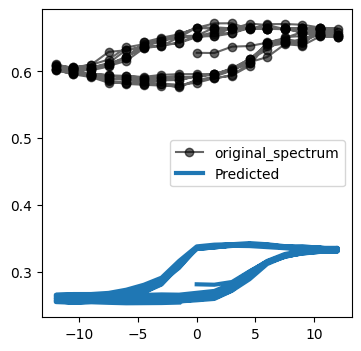

(1, 256) (1, 256)


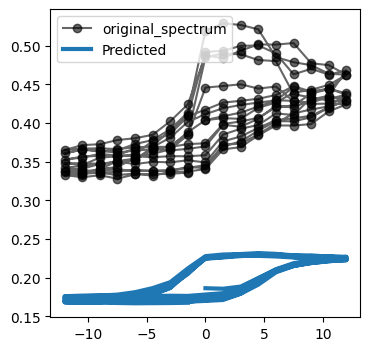

(1, 256) (1, 256)


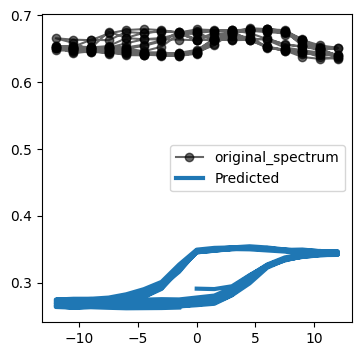

(1, 256) (1, 256)


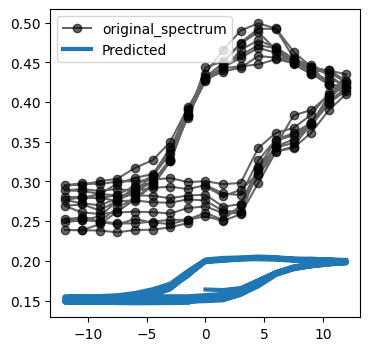

(1, 256) (1, 256)


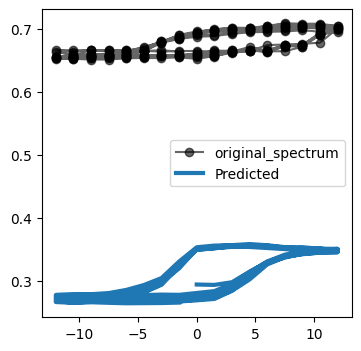

(66, 16, 16, 1) (66, 256) (66,)
Training set shape: (198, 16, 16, 1) (198, 256)
Training deterministic NN...


Training Progress: 100%|██████████| 500/500 [00:10<00:00, 47.17it/s, Epoch 500/500, LR: 0.010000, Loss: 0.0595 ] 


Training partially Bayesian NN


sample: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it, 3 steps of size 4.61e-03. acc. prob=0.82]


(1, 256) (1, 256)


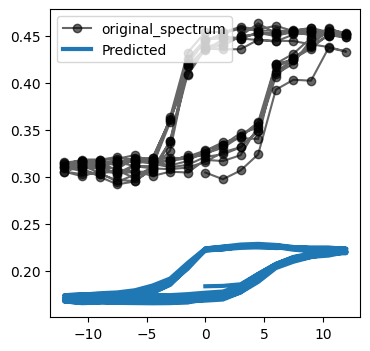

(1, 256) (1, 256)


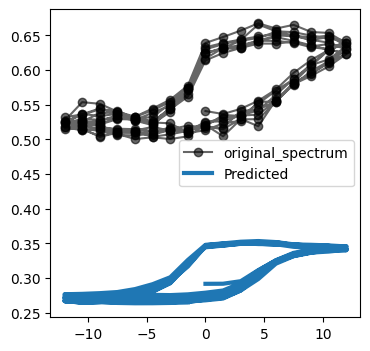

(1, 256) (1, 256)


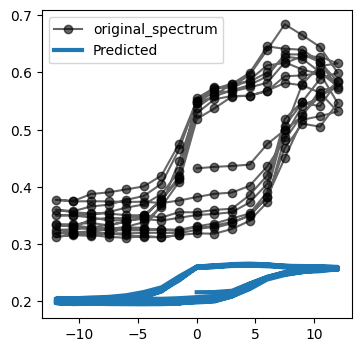

(1, 256) (1, 256)


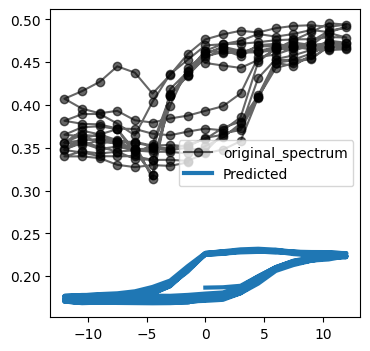

(1, 256) (1, 256)


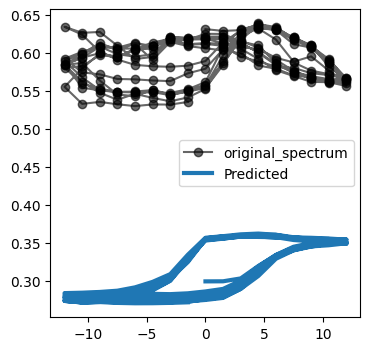

(71, 16, 16, 1) (71, 256) (71,)


In [42]:
exploration_steps = 2
error_log = []
random_error_log = []
trainset_errors = []
testset_errors = []
fitting_errors = []
pred_errors =[]


for i in range(exploration_steps):

    # Train the model

    if augment_dataset:
        images_to_train, spectra_to_train = augmented_dataset_numpy(imgs_train, spectra_train)
    else:
        images_to_train, spectra_to_train = imgs_train, spectra_train

    print("Training set shape:", images_to_train.shape, spectra_to_train.shape)

    # model = nb.PartialBNN(architecture, probabilistic_layer_names= probabilistic_layer_names)

    # model.fit(images_to_train, spectra_to_train, num_warmup= 10, num_samples=10)


    model =  train_model(architecture, probabilistic_layer_names, images_to_train, spectra_to_train, warmup_epochs=10, sample_epochs=10)

    # Get the trained model to calulate the predictive mean and variance
    posterior_mean, posterior_var = model.predict(images)

    cumulative_var = np.mean(posterior_var, axis=1)
    spectral_error = spectral_mismatch_error(posterior_mean, spectra)


    # Use acquisition function to select the next points

    acq_ind, acq_vals = distance_acq_fn(posterior_var, beta = beta, lambda_ = lambda_, sample_next_points = sample_next_points, exclude_indices = indices_train)


    # Plot the variance map and the acquisition function

    trainset_errors.append(cumulative_var[indices_train].mean())
    testset_errors.append(cumulative_var[indices_test].mean())
    fitting_errors.append(cumulative_var.mean())


    # Compare the output with random samplinng

    for ind in acq_ind:

        ind = random.choice(indices_test)

        # Acquisition point
        next_coordinate = coordinates[ind]
        predicted_spectra = posterior_mean[ind:ind+1]
        print(predicted_spectra.shape, spectra[ind:ind+1].shape)

        spectral_error= spectral_mismatch_error(predicted_spectra, spectra[ind:ind+1])
        error_log.append(spectral_error.mean())

        #plot_spectra(predicted_spectra, spectra[ind], spectral_error.mean(), xdata = vstep)



        #Randomly sampled point
        rand_ind = random.choice(indices_test)

        rand_spectral_error = spectral_mismatch_error(posterior_mean[rand_ind: rand_ind+1], spectra[rand_ind:rand_ind+1])
        random_error_log.append(rand_spectral_error.mean())

        # Update train and test sets
        imgs_train, spectra_train, indices_train = append_training_set(images, spectra, ind, imgs_train, spectra_train, indices_train)
        indices_test = np.delete(indices_test, np.where(indices_test == ind))

        imgs_test, spectra_test =  images[indices_test], spectra[indices_test]




    print(imgs_train.shape, spectra_train.shape, indices_train.shape)


    # append the acquisition index into the training set.



error_log = np.asarray(error_log)
random_error_log = np.asarray(random_error_log)
trainset_errors =  np.asarray(trainset_errors)
testset_errors =  np.asarray(testset_errors)
fitting_errors =  np.asarray(fitting_errors)

In [44]:
error_log = np.asarray(error_log)
random_error_log = np.asarray(random_error_log)
trainset_errors =  np.asarray(trainset_errors)
testset_errors =  np.asarray(testset_errors)
fitting_errors =  np.asarray(fitting_errors)

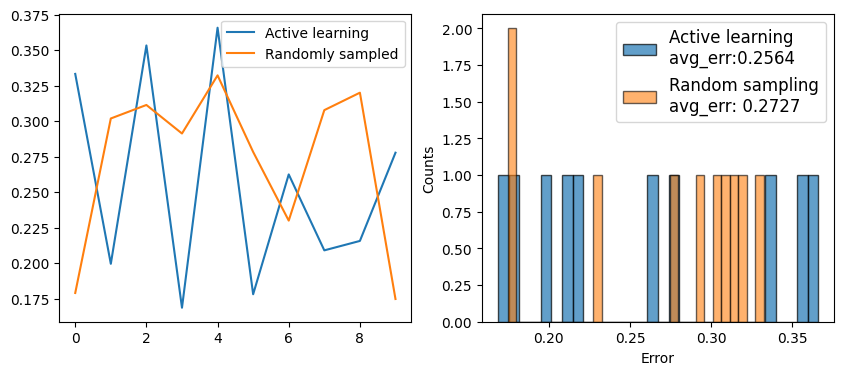

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(error_log, label = f'Active learning')
ax[0].plot(random_error_log, label = f'Randomly sampled')
ax[0].legend()

ax[1].hist(error_log, bins=30, alpha=0.7, label=f'Active learning\navg_err:{error_log.mean():.4f}', color='#1f77b4', edgecolor='black')
ax[1].hist(random_error_log, bins=30, alpha=0.6, label=f'Random sampling\navg_err: {random_error_log.mean():.4f}', color='#ff7f0e', edgecolor='black')
ax[1].set_xlabel('Error')
ax[1].set_ylabel('Counts')
ax[1].legend(fontsize = 'large')

plt.show()

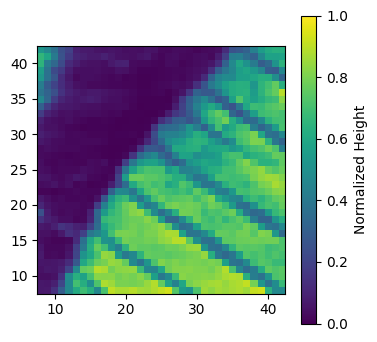

In [50]:
# PLot exploration points on the topography data

plt.figure(figsize = [4, 4])
a =plt.imshow(full_image, origin = 'lower')

for ind in indices_train[initial_trainsize:]:
    plt.scatter(coordinates[ind, 1], coordinates[ind, 0], c = 'r', s = 15)

plt.colorbar(a, label = 'Normalized Height')
plt.ylim(7.5, 42.5)
plt.xlim(7.5, 42.5)
plt.show()
